In [47]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
from meep_material import lorentzfit

In [48]:
resolution = 100
nfreq = 300
fcen = 1.75
df = 3.3

In [50]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=50
                       ):    
        # 1. 데이터 로드 및 전처리,
        data = np.genfromtxt(Material_data_csv, delimiter=",")
        wl = data[:, 0] * 1e6  # 파장 (µm),
        n_data = data[:, 1] + 1j * data[:, 2]
        eps_all = np.square(n_data) - eps_inf
    
        # 피팅 범위로 데이터 선택,
        mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
        wl_fit, eps_fit = wl[mask], eps_all[mask]
        freqs_fit = 1 / wl_fit
    
        # 2. Lorentzian 피팅 최적화,
        ps = np.zeros((iteration, 3 * num_lorentzians))
        errors = np.zeros(iteration)
        for m in range(iteration):
            p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
            ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
            print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
        best = np.argmin(errors)
        print(f"Optimal error: {errors[best]:.6f}")
    
        # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성,
        suscept = []
        for i in range(num_lorentzians):
            freq_param = ps[best][3*i + 1]
            gamma = ps[best][3*i + 2]
            if freq_param == 0:
                sigma = ps[best][3*i + 0]
                suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
            else:
                sigma = ps[best][3*i + 0] / freq_param**2
                suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))
    
        return eps_inf, suscept
    
sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/merged_sio2_eps.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/merged_al_eps.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/merged_aNDP_eps.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000000
Iteration   1, error: 0.000000
Iteration   2, error: 0.000000
Iteration   3, error: 0.000000
Iteration   4, error: 0.000000
Iteration   5, error: 0.000000
Iteration   6, error: 0.000000
Iteration   7, error: 0.000000
Iteration   8, error: 0.000000
Iteration   9, error: 0.000000
Iteration  10, error: 0.000000
Iteration  11, error: 0.000000
Iteration  12, error: 0.000000
Iteration  13, error: 0.000000
Iteration  14, error: 0.000000
Iteration  15, error: 0.000000
Iteration  16, error: 0.000000
Iteration  17, error: 0.000000
Iteration  18, error: 0.000000
Iteration  19, error: 0.000000
Iteration  20, error: 0.000000
Iteration  21, error: 0.000000
Iteration  22, error: 0.000000
Iteration  23, error: 0.000000
Iteration  24, error: 0.000000
Iteration  25, error: 0.000000
Iteration  26, error: 0.000000
Iteration  27, error: 0.000000
Iteration  28, error: 0.000000
Iteration  29, error: 0.000000
Iteration  30, error: 0.000000
Iteration  31, error: 0.000000
Iteratio

In [51]:
### ----- Refractive index ----- ###,
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 ,
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP ,
Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

# Cathode = mp.perfect_electric_conductor,

CoverLayer = mp.Medium(index=1.9) # SiN ,
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기,

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

PML_layer = 0.5

boundary_layers = [
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.Low),  # 좌측 PML,
    mp.PML(thickness=PML_layer, direction=mp.X, side=mp.High), # 우측 PML,
    mp.PML(thickness=PML_layer, direction=mp.Y, side=mp.High), # 상단 PML,
]

Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [52]:
cell_size = mp.Vector3(30, 2, 0)

geometry_fitting_Al = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 0),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(mp.inf, Alq3_layer, 0),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(mp.inf, aNDP_layer, 0),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(mp.inf, ITO_layer, 0),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(mp.inf, Cover_layer, 0),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(mp.inf, Glass_layer, 0),
            material=Glass
        )
]

source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0)
)]

In [53]:
# === 시뮬레이션 설정 === #
sim_fitting_Al = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_fitting_Al,
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
)

In [219]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting_Al = sim_fitting_Al.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y, 
                  weight=-1),
    # mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
    #               size=mp.Vector3(0, flux_size),
    #               # direction=mp.Y
    #             ),
    # mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
    #               size=mp.Vector3(flux_size, 0),
    #               # direction=mp.Y, 
    #               weight=-1),
    # mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
    #               size=mp.Vector3(flux_size, 0),
    #               # direction=mp.Y
    #               )
)

# sim_fitting_Al.run(until_after_sources = mp.stop_when_fields_decayed(1e-5, mp.Ex, source_center, 0), until = 200)

sim_fitting_Al.run(until = 10)
net_power_fitting_al = mp.get_fluxes(box_power_fitting_Al)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000328779 s
Working in 2D dimensions.
Computational cell is 30 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (1e+20,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (1e+20,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (1e+20,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (1e+20,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (1e+20,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.6

In [220]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# === 설정 ===
resolution = 100
cell_size = mp.Vector3(3, 3, 0)
fcen = 1.75       # Gaussian source 중심 주파수
df = 3.3          # Gaussian source 대역폭
nfreq = 300

field_component = mp.Ex  # 원하는 필드 성분

# === 측정할 파장 범위 (0.4 ~ 0.7 μm) ⇒ 주파수로 변환 ===
lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_max   # ≈ 1.4286
fmax = 1 / lambda_min   # = 2.5
fcen_dft = 0.5 * (fmin + fmax)
df_dft = fmax - fmin

# === 소스 위치 ===
source_center = mp.Vector3(0, 0, 0)
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=field_component,
        center=source_center,
        size=mp.Vector3(0, 0)
    )
]

pml_layers = [mp.PML(0.3)]


# === 시뮬레이션 ===
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    default_material=mp.Medium(index=1.0),
    sources=sources,
    resolution=resolution
)

offset = 0.01
flux_size = 0.02
source_center = mp.Vector3(0, 0)

flux_box = sim.add_flux(
    fcen_dft, df_dft, nfreq,
    
    # x1
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size), weight=-1),
    # # x2
    # mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
    #               size=mp.Vector3(0, flux_size)),
    # # y1
    # mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
    #               size=mp.Vector3(flux_size, 0), weight=-1),
    # # y2
    # mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
    #               size=mp.Vector3(flux_size, 0))
)

sim.run(until=10)
P_air = mp.get_fluxes(flux_box)
wavelengths = 1 / np.array(mp.get_flux_freqs(flux_box))


-----------
Initializing structure...
time for choose_chunkdivision = 0.000123978 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 100
time for set_epsilon = 0.0456891 s
-----------
run 0 finished at t = 10.0 (2000 timesteps)


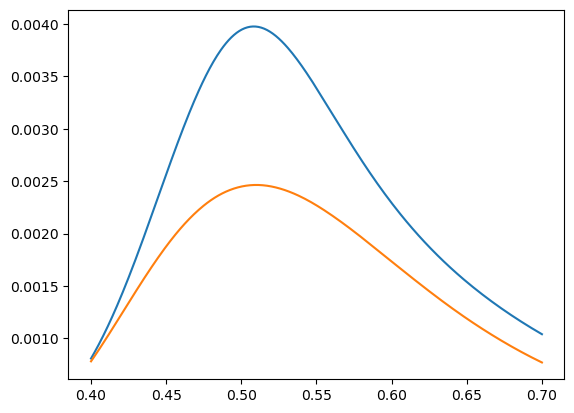

In [224]:
norm = np.array(net_power_fitting_al) / np.array(P_air)

plt.plot(wavelengths, net_power_fitting_al)
plt.plot(wavelengths, P_air)
plt.show()
# plt.xlim(0.4, 0.7)
# plt.ylim(-0.2e-9, 1e-10)

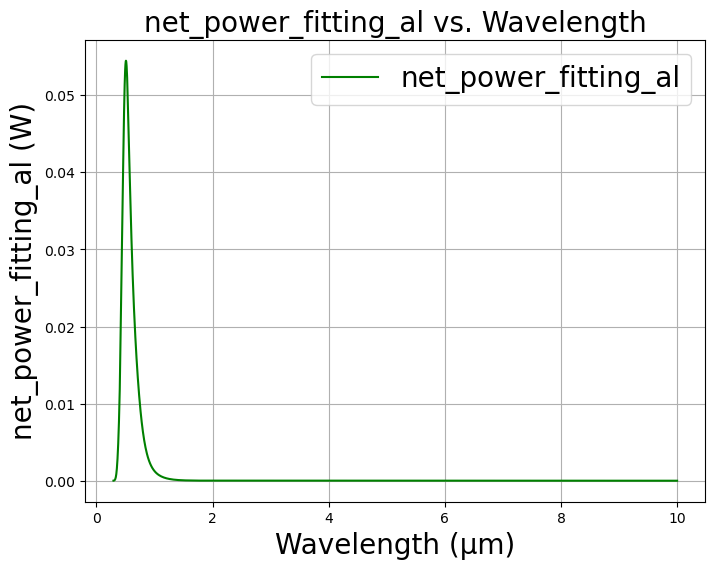

In [197]:
frequencies = mp.get_flux_freqs(box_power_fitting_Al)
wavelengths = [1/f for f in frequencies]

plt.figure(figsize=(8,6))
plt.plot(wavelengths, net_power_fitting_al, '-', label='net_power_fitting_al', color = 'green')
plt.xlabel('Wavelength (μm)', fontsize = 20)
plt.ylabel('net_power_fitting_al (W)', fontsize = 20)
plt.title('net_power_fitting_al vs. Wavelength', fontsize = 20)

plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

### resolution 1000 - air(sourcepower)

In [198]:
from src_resolution import sourcepower

src_wavelengths, src_power = sourcepower(100)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000149965 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 100
time for set_epsilon = 0.045208 s
-----------
run 0 finished at t = 50.0 (10000 timesteps)
CSV 파일 저장 완료: sourcepower_res100.csv


In [199]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/RESOLUTION/full/full100.txt")

# CSV 파일 불러오기
lumerical_data = np.genfromtxt(csv_path, delimiter=",")

lumerical = lumerical_data[:, 1]

In [200]:
# lumerical data import
import numpy as np
from pathlib import Path

csv_path = Path("/home/m2ni/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/ldos_sourcepower_res100.csv")

# CSV 파일 불러오기
air_1000_data = np.genfromtxt(csv_path, delimiter=",", skip_header=1)

air_1000 = air_1000_data[:, 1]

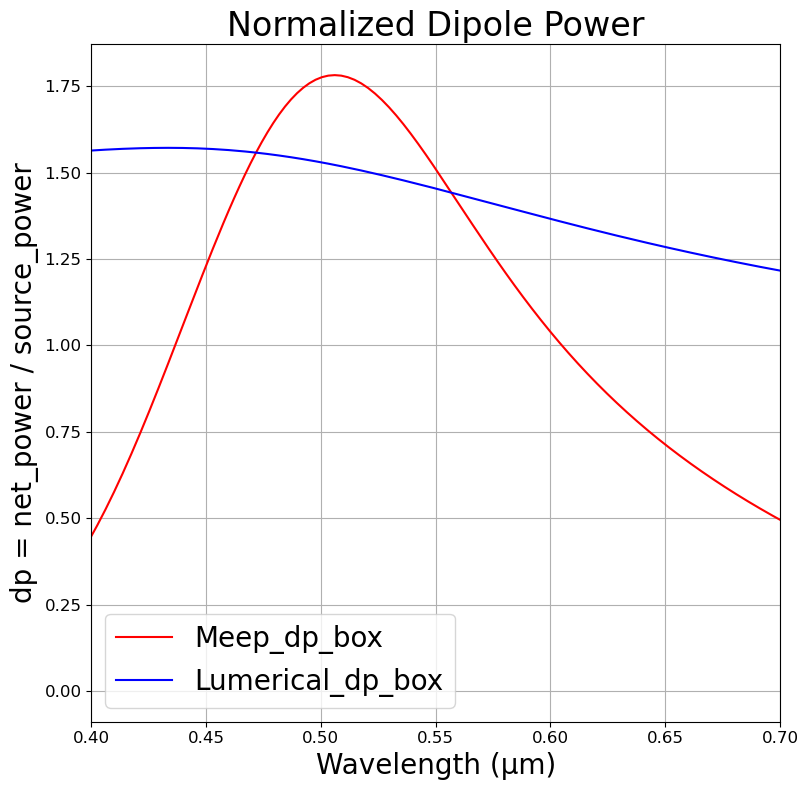

In [204]:
# dp_box / sourcepower 정규화
dp_fitting_al = net_power_fitting_al / src_power

plt.figure(figsize=(8, 8))

# plot 순서
plt.plot(wavelengths, dp_fitting_al, label='Meep_dp_box', color='red')
plt.plot(wavelengths, lumerical, label='Lumerical_dp_box', color='blue')
# plt.plot(wavelength_sliced_al_nofunc, Al_power_sliced_nofunc, label='Lumerical dp', color='green')


# 축 레이블 (굵게 + 크기 조정)
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("dp = net_power / source_power", fontsize=20)

# 제목 (굵게 + 크기 조정)
plt.title("Normalized Dipole Power", fontsize=24)

# 눈금 폰트 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 범례 (폰트 크기 조정 + 굵게)
plt.legend(fontsize=20, frameon=True,)

# 기타 설정
plt.grid(True)
plt.tight_layout()
# plt.ylim([0, 1.5])
plt.xlim([0.4, 0.7])
plt.show()

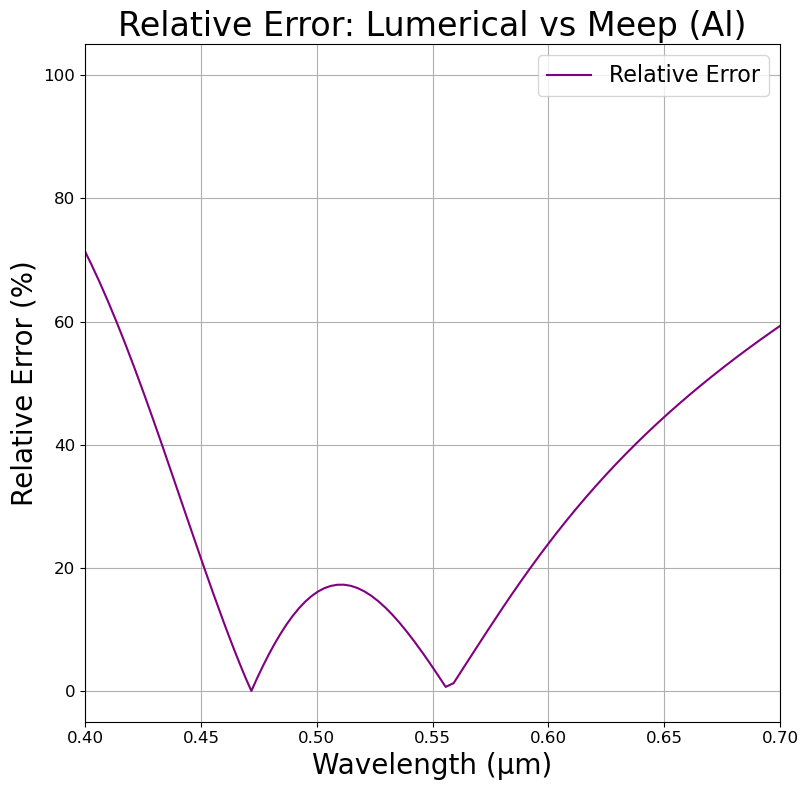

In [203]:
# === Relative Error 계산 === #
relative_error = np.abs((dp_fitting_al - lumerical) / lumerical)* 100

# relative_error_nofunc = np.abs((Al_power_sliced_nofunc - dp_fitting_al) / dp_fitting_al)* 100


# === Relative Error 플롯 === #
plt.figure(figsize=(8, 8))
plt.plot(wavelengths, relative_error, label='Relative Error', color='purple')
# plt.plot(wavelengths, relative_error_nofunc, label='Relative Error dp_box', color='cyan')


# 축 레이블
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("Relative Error (%)", fontsize=20)

# 제목
plt.title("Relative Error: Lumerical vs Meep (Al)", fontsize=24)

# 눈금, 범례
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xlim([0.4, 0.7])
plt.show()
